In [47]:
import os
from pathlib import Path
from math import log, sqrt, pi, exp, floor
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from datetime import datetime, date, timedelta
import numpy as np
from yahoo_fin import options
from yahoo_fin import stock_info as si

In [48]:
### American option pricers (Binomial Tree) ###
def binomial_american_option_pricer (optionType, S, K, t, t_q, r, q, vola, N, getTheta=False):
    u = exp(vola*sqrt(t/N))
    d = 1./u
    R = exp(r*t/N)
    p = (R-d)/(u-d)

    #Create vector of lumpy dividends
    dividend = np.zeros(N + 1)

    if t_q > 0 and t_q <= t:
        div_index = int(floor(t_q/t * N))

        for n in range(div_index):
            dividend[n] = q / (R ** (div_index - n))

    #Build price tree deducting the dividend
    stock = np.zeros([N + 1, N + 1])
    for n in range(N + 1):
        for j in range(n + 1):
            stock[n, j] = (S - dividend[0]) * (u ** j) * (d ** (n - j)) + dividend[n]
    
    option = np.zeros([N + 1, N + 1])

    if optionType == "Call":
        # Generate option prices recursively
        option[N, :] = np.maximum(np.zeros(N + 1), stock[N, :] - K)

        for n in range(N - 1, -1, -1):
            for j in range(n + 1):
                option[n, j] = (
                np.maximum(stock[n, j] - K, (p * option[n + 1, j + 1] + (1 - p) * option[n + 1, j]) / R)
                )
    elif optionType == "Put":
        # Generate option prices recursively
        option[N, :] = np.maximum(np.zeros(N + 1), K - stock[N, :])

        for n in range(N - 1, -1, -1):
            for j in range(n + 1):
                option[n, j] = (
                np.maximum(K - stock[n, j], (p * option[n + 1, j + 1] + (1 - p) * option[n + 1, j]) / R)
                )
    else:
        print("UNRECOGNIZED OPTION TYPE")
    
    if getTheta==False:
        return option[0, 0]
    else:
        return (option[2, 1] - option[0, 0]) / (2 * t / N)

def binomial_delta(optionType, S, K, t, t_q, r, q, vola, N, h):
    return (
            binomial_american_option_pricer(optionType, S + h, K, t, t_q, r, q, vola, N)
            - binomial_american_option_pricer(optionType, S - h, K, t, t_q, r, q, vola, N)
    ) / (2*h)

def binomial_gamma(optionType, S, K, t, t_q, r, q, vola, N):
    u = exp(vola*sqrt(t/N))
    d = 1./u
    return 2 / (u**2*S - d**2*S) * (
        (
            binomial_american_option_pricer(optionType, u**2*S, K, t, t_q, r, q, vola, N) -
            binomial_american_option_pricer(optionType, S, K, t, t_q, r, q, vola, N)
        )
            /
        (
            u**2*S - S
        )
            - 
        (
            binomial_american_option_pricer(optionType, S, K, t, t_q, r, q, vola, N) -
            binomial_american_option_pricer(optionType, d**2*S, K, t, t_q, r, q, vola, N)
        )
            /
        (
            S - d**2*S
        )
    )
def binomial_vega(optionType, S, K, t, t_q, r, q, vola, N, h):
    return (
            binomial_american_option_pricer(optionType, S, K, t, t_q, r, q, vola + h, N)
            - binomial_american_option_pricer(optionType, S, K, t, t_q, r, q, vola - h, N)
    ) / (2*h)

print(binomial_american_option_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=1.3759, N=10, optionType="Call"))
print(binomial_american_option_pricer(S=100, K=100, vola=0.15, t=1., t_q=1., r=0.1, q=0, N=10, optionType="Put"))

10.824553031824337
3.07621086348687


In [49]:
### Binomial american implied volatility calculation formulas ###

def iv_binomial_american_option(optionType, S, K, t, t_q, r, q, N, market_price, a=0.01, b=2.0, xtol=1e-6):
    _optionType, _S, _K, _t, _t_q, _r, _q, _N, _market_price = optionType, S, K, t, t_q, r, q, N, market_price
    
    # define a nested function with only volatility as input
    def call_iv_objective_func(vola):
        return _market_price - binomial_american_option_pricer(_optionType, _S, _K, _t, _t_q, _r, _q, vola, _N)
    
    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(call_iv_objective_func, a=a, b=b, xtol=xtol)

        # if the results are too small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result
    
    except ValueError:
        return np.nan

#Test functions
S = 45.0
K = 45.0
t = 20/365
t_q = 20/365
r = 0.009
q = 0.0139
vola = 0.25
N = 200

call_price = binomial_american_option_pricer("Call", S, K, t, t_q, r, q, vola, N)
put_price = binomial_american_option_pricer("Put", S, K, t, t_q, r, q, vola, N)
print(call_price)
print(put_price)
print('Make sure that '+ str(iv_binomial_american_option("Call", S, K, t, t_q, r, q, N, call_price)) + ' is close to 0.25')
print('Make sure that '+ str(iv_binomial_american_option("Put", S, K, t, t_q, r, q, N, put_price)) + ' is close to 0.25')

1.0596161269664648
1.0449373998760096
Make sure that 0.25000000000344036 is close to 0.25
Make sure that 0.2500000000007256 is close to 0.25


In [50]:
### Market data fetch ###
def get_spot(ticker):
    return si.get_live_price(ticker)

ticker = "spy"
option_series = datetime(2021, 11, 19)
chain = options.get_options_chain(ticker, option_series)
call_chain = chain["calls"]
put_chain = chain["puts"]
options.get_expiration_dates(ticker);
S = get_spot("spy")

In [51]:
### Calculate time to expiration ###
expiration_date = option_series + timedelta(hours=16)
ex_dividend_date = datetime(2021, 9, 17)
minutes_in_a_year=365*24*60
t = floor((expiration_date - datetime.now()).total_seconds() / 60.) / minutes_in_a_year
t_q = floor((ex_dividend_date - datetime.now()).total_seconds() / 60 )/ minutes_in_a_year

In [52]:
pd.set_option('display.max_rows', 500) #Show n Dataframe rows
print(call_chain)
print(put_chain)

          Contract Name         Last Trade Date  Strike  Last Price     Bid  \
0    SPY211119C00200000   2021-08-25 5:22PM EDT   200.0      197.29  251.62   
1    SPY211119C00210000   2021-08-25 5:22PM EDT   210.0      196.85  241.62   
2    SPY211119C00215000   2021-08-25 5:22PM EDT   215.0      191.81  236.62   
3    SPY211119C00220000   2021-08-25 5:22PM EDT   220.0      225.60  231.62   
4    SPY211119C00225000   2021-08-25 5:22PM EDT   225.0      182.13  226.62   
5    SPY211119C00230000   2021-08-25 5:22PM EDT   230.0      180.36  221.62   
6    SPY211119C00235000   2021-08-25 5:22PM EDT   235.0      172.27  216.62   
7    SPY211119C00240000   2021-08-25 5:22PM EDT   240.0      199.27  211.62   
8    SPY211119C00245000   2021-08-25 5:22PM EDT   245.0      200.00  206.63   
9    SPY211119C00250000   2021-08-25 5:22PM EDT   250.0      193.14  201.63   
10   SPY211119C00265000  2021-08-23 12:35PM EDT   265.0      183.02  186.63   
11   SPY211119C00270000   2021-08-25 5:22PM EDT   27

In [53]:
### Organize the data ###
call_chain["Mid Price"] = (call_chain["Ask"] - call_chain["Bid"])/2. + call_chain["Bid"]
put_chain["Mid Price"] = (put_chain["Ask"] - put_chain["Bid"])/2. + put_chain["Bid"]

data = {"Strike" : call_chain["Strike"],
        "CallPrice" : call_chain["Mid Price"]}
data_chain = pd.DataFrame(data)

#Combine call and put prices by strike
for i, row in call_chain.iterrows():
    data_chain.loc[i, 'PutPrice'] = next(iter(put_chain.loc[put_chain['Strike'] == row['Strike']]['Mid Price']), np.nan)
    
#Clean up data
for i, row in data_chain.iterrows():
    if data_chain.loc[i, 'CallPrice'] < 0.05 or data_chain.loc[i, 'PutPrice'] < 0.05:
        data_chain.drop(index=i, inplace=True)
data_chain.dropna(inplace=True)
data_chain.reset_index(drop=True, inplace=True)
print(data_chain)

     Strike  CallPrice  PutPrice
0     200.0    252.100     0.075
1     210.0    242.100     0.085
2     215.0    237.095     0.095
3     220.0    232.095     0.115
4     225.0    227.100     0.125
5     230.0    222.100     0.135
6     235.0    217.100     0.155
7     240.0    212.095     0.175
8     245.0    207.105     0.185
9     250.0    202.105     0.205
10    265.0    187.105     0.275
11    270.0    182.100     0.305
12    275.0    177.105     0.335
13    280.0    172.150     0.365
14    285.0    167.145     0.405
15    290.0    162.165     0.445
16    300.0    152.205     0.535
17    305.0    147.235     0.580
18    309.0    143.255     0.625
19    310.0    142.260     0.635
20    311.0    141.265     0.645
21    313.0    139.275     0.670
22    315.0    137.320     0.695
23    318.0    134.335     0.730
24    320.0    132.345     0.755
25    321.0    131.350     0.770
26    322.0    130.355     0.785
27    323.0    129.360     0.795
28    324.0    128.365     0.810
29    325.

In [54]:
### Calibrate r so that ATM vols are the same, q should be known ###
q = 1.3759 #dividend in dollars
r = 0.00465
N = 250

#Find strike where call and put prices are the closest
data_chain["PriceDelta"] = abs(data_chain["CallPrice"] - data_chain["PutPrice"])
minDiff = min(data_chain["PriceDelta"])
atm_strike = next(iter(data_chain.loc[data_chain["PriceDelta"] == minDiff]["Strike"]), np.nan)
atm_call_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["CallPrice"]), np.nan)
atm_put_price = next(iter(data_chain.loc[data_chain["Strike"] == atm_strike]["PutPrice"]), np.nan)

#Calculate ATM vols
iv_call = iv_binomial_american_option("Call", S, atm_strike, t, t_q, r, q, N, atm_call_price)
iv_put = iv_binomial_american_option("Put", S, atm_strike, t, t_q, r, q, N, atm_put_price)
print("Strike / Call IV / Put IV")
print(atm_strike, iv_call, iv_put)

Strike / Call IV / Put IV
451.0 0.14160068123664998 0.14161070758779346


In [55]:
#Build volatility smile
data = {"ATM" : (vol_data["Strike"] == atm_strike),
        "Strike" : data_chain["Strike"],
        "CallImpliedVol" : 0,
        "PutImpliedVol" : 0,
        "DriftRate" : 0
       }
vol_data = pd.DataFrame(data)
for i, row in data_chain.iterrows():
    #Compute implied volatility
    vol_data.loc[i, 'CallImpliedVol'] = iv_binomial_american_option("Call", S, row["Strike"], t, t_q, r, q, N, row["CallPrice"])
    vol_data.loc[i, 'PutImpliedVol'] = iv_binomial_american_option("Put", S, row["Strike"], t, t_q, r, q, N, row["PutPrice"])
    print(str(i) + "..", end="")
vol_data["DriftRate"] = r
print("")
print("Done")

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..101..102..103..104..105..106..107..108..109..110..111..112..113..114..115..116..117..118..119..120..121..122..123..124..125..126..127..128..129..130..131..132..133..134..135..136..137..138..139..140..141..142..143..144..145..146..147..148..149..150..151..152..153..154..155..156..157..158..159..160..161..162..163..164..165..166..167..
Done


In [56]:
print(vol_data)

       ATM  Strike  CallImpliedVol  PutImpliedVol  DriftRate
0    False   200.0        0.850104       0.634558    0.00465
1    False   210.0        0.802726       0.605794    0.00465
2    False   215.0        0.778399       0.595567    0.00465
3    False   220.0        0.756179       0.589341    0.00465
4    False   225.0        0.735983       0.577096    0.00465
5    False   230.0        0.714751       0.565127    0.00465
6    False   235.0        0.693624       0.557098    0.00465
7    False   240.0        0.671861       0.547368    0.00465
8    False   245.0        0.653520       0.534339    0.00465
9    False   250.0        0.633652       0.525049    0.00465
10   False   265.0        0.576449       0.494698    0.00465
11   False   270.0        0.557261       0.485796    0.00465
12   False   275.0        0.540161       0.475341    0.00465
13   False   280.0        0.530198       0.465080    0.00465
14   False   285.0        0.511978       0.456792    0.00465
15   False   290.0      

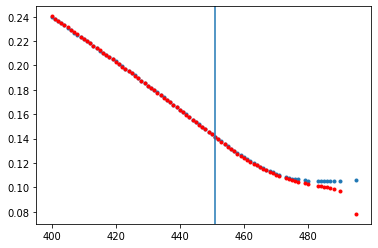

In [57]:
### Plot volatility data ###
x_min = 400
x_max = 495
plot_data = vol_data[(vol_data["Strike"] >= x_min) & (vol_data["Strike"] <= x_max)]
plt.plot(plot_data["Strike"], plot_data["CallImpliedVol"], '.')
plt.plot(plot_data["Strike"], plot_data["PutImpliedVol"], 'r.')
plt.autoscale(enable=True, axis='y')
plt.axvline(x=atm_strike)
plt.show()

In [58]:
### Save to CSV file ###
def vol_csv_path(ticker, option_series, data_date=datetime.now()):
    pass

#Save data to CSV
now = datetime.now()
path = r"vols"
path = os.path.join(path, str(ticker))
series_path = r"series_" + str(option_series.year) + r"-" + str(option_series.month) + r"-" + str(option_series.day)
path = os.path.join(path, series_path)
Path(path).mkdir(parents=True, exist_ok=True)
file_name = str(ticker) + "_series_" + str(expiration_date.month) \
            + r"-" + str(expiration_date.day) + r"_" + str(now.year) + r"-" \
            + str(now.month) + r"-" + str(now.day) +  r".csv"
vol_data.to_csv(os.path.join(path, file_name), index=False)

# Compute Greeks

In [73]:
### Fetch volatility data from CSV ###
def read_vol_csv(ticker, option_series, data_date=datetime.now()):
    path = r"vols"
    path = os.path.join(path, str(ticker))
    series_path = r"series_" + str(option_series.year) + r"-" + str(option_series.month) + r"-" + str(option_series.day)
    path = os.path.join(path, series_path)
    file_name = str(ticker) + "_series_" + str(option_series.month) \
                + r"-" + str(option_series.day) + r"_" + str(data_date.year) + r"-" \
                + str(data_date.month) + r"-" + str(data_date.day) +  r".csv"
    vol_data = pd.read_csv(os.path.join(path, file_name))
    return vol_data

In [72]:
### Options info ###
ticker = "spy"
option_series = datetime(2021, 11, 19)
optionType = "Call"
K = 460 #Choose strike

csv_data = read_vol_csv(ticker, option_series)

#Compute Greeks
expiration_date = option_series + timedelta(hours=16)

#S = next(iter(csv_data.loc[vol_data["ATM"] == True]["Strike"]), np.nan)
S = get_spot(ticker)
vol = next(iter(csv_data.loc[vol_data["Strike"] == K]["PutImpliedVol"]), np.nan)
t = floor((expiration_date - datetime.now()).total_seconds() / 60.) / minutes_in_a_year
r = csv_data.loc[0, "DriftRate"]

delta = binomial_delta(optionType, S, K, t, t_q, r, q, vol, N, 1)
gamma = binomial_gamma(optionType, S, K, t, t_q, r, q, vol, N)
theta = binomial_american_option_pricer(optionType, S, K, t, t_q, r, q, vol, N, getTheta=True)
vega = binomial_vega(optionType, S, K, t, t_q, r, q, vol, N, 0.01)

print(optionType, "strike: ", K, " Exp. "+str(option_series.year)+"-"+str(option_series.month)+"-"+str(option_series.day))
print("Delta: ", delta)
print("Gamma: ", gamma)
print("Theta: ", theta)
print("Vega: ", vega)

KeyboardInterrupt: 

0.00465
